This notebook demonstrates a number of examples of how AEM data stored within netCDF format is used during analysis. Many of the tools are developed as part of the hydrogeol_utils package (https://github.com/Neil-Symington/hydrogeol_utils), a package developed in house fo visualising, integrating and analysing high performance geoscientific data for groundwater assessments.

The rationale for using the netCDF and other high performance data formats within this environment is that it allows the development of scientific workflows that are repeatable. This not only increases the efficiency as workflows can be reused on new datasets but also makes the science transparent as it relies on open source packages.

I really appreciate the netCDF4 python api as it allows me to easily query large datasets and pull the data I want into memeory and process, analyse and visualise it using python based tools.

Neil Symington
neil.symington@ga.gov.au

In [1]:
# Import packages
from sqlite3 import dbapi2 as sqlite
import pandas as pd
import fiona
from shapely.geometry import Polygon, shape, Point, MultiPoint
import numpy as np
# My own functions developed to work on datasets
from hydrogeol_utils import spatial_functions, AEM_utils
from hydrogeol_utils import plotting_utils as plot_utils
from hydrogeol_utils import borehole_utils, SNMR_utils, grid_utils
# Functions from geophys utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from geophys_utils._netcdf_line_utils import NetCDFLineUtils
from geophys_utils.netcdf_converter import netcdf2aseg_gdf_converter
from geophys_utils import points2convex_hull
import matplotlib.pyplot as plt
import os
import math
import time
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import rasterio
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
from hydrogeol_utils.db_utils import makeCon, closeCon
import numpy.ma as ma



In [3]:
def plot_AEM_data(dataset, index,error_bars = True):
    fig, ax = plt.subplots(1)
    
    # Extract data into arrays
    lm_dat= dataset['low_moment_Z-component_EM_data'][index]
    lm_runc = dataset['rel_uncertainty_low_moment_Z-component'][index]
    lm_unc = np.multiply(lm_dat, lm_runc)
    
    hm_dat= dataset['high_moment_Z-component_EM_data'][index]
    hm_runc = dataset['rel_uncertainty_high_moment_Z-component'][index]
    hm_unc = np.multiply(hm_dat, hm_runc)
    
    # Get the gate times
    lm_window_times = dataset['Receiver']['low_moment_window_time'][:].mean(axis = 1)
    hm_window_times = dataset['Receiver']['high_moment_window_time'][:].mean(axis = 1)
    
    if error_bars:
        ax.errorbar(lm_window_times, lm_dat,
                    xerr= None, yerr = lm_unc,
                    label= 'low-moment data')
    
        ax.errorbar(hm_window_times, hm_dat,
                    xerr= None, yerr = hm_unc,
                    label= 'high-moment data')
    else:
        ax.scatter(lm_window_times, lm_dat,
                    label= 'low-moment data')
    
        ax.scatter(hm_window_times, hm_dat,
                    label= 'high-moment data')
    
    ax.set_yscale('log')
    
    ax.set_xscale('log')
    
    # Set limits
    ax.set_xlim(10**-5, 10**-1)
    ax.set_ylim(10**-5, 10**5)
    ax.grid(True)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('dB/dt ' + dataset['low_moment_Z-component_EM_data'].units)
    fig.legend()
    
    plt.show()

In [ ]:
# Simple block of code for converting aseg gdf format to netcdf

# Normally takes ~5 minutes for a ~2GB AEM datafile

root = r"D:\East_Kimberley\Data\Original\AEM\OrdKeep_SkyTEM_190117\03_LCI\01_Data"
nc_out_path = os.path.join(root, "OrdK_WB_MGA52.nc")

dat_in_path = os.path.join(root, 'OrdK_WB_MGA52.dat')

dfn_in_path = os.path.join(root, 'OrdK_WB_MGA52.dfn')
crs_string = "EPSG:28352"

if os.path.exists(nc_out_path):
    os.remove(nc_out_path)

d2n = aseg_gdf2netcdf_converter.ASEGGDF2NetCDFConverter(nc_out_path, 
                                                 dat_in_path, 
                                                 dfn_in_path,
                                                 crs_string,
                                                 fix_precision=True,
                                                 remove_null_columns = False)
d2n.convert2netcdf()    

In [4]:
# Open the AEM data file
nc_dir = r"C:\Users\PCUser\Desktop\EK_data\AEM\netCDF"

nc_inpath = os.path.join(nc_dir, "AUS_10021_OrdK_EM.nc")

d = netCDF4.Dataset(nc_inpath, "r")

In [10]:
d['low_moment_Z-component_EM_data']

<class 'netCDF4._netCDF4.Variable'>
float64 low_moment_Z-component_EM_data(point, low_moment_gate)
    long_name: Z-component Low Moment dB/dt processed and normalised
    aseg_gdf_format: 26F15.5
    units: pV/(A.turns.m4)
unlimited dimensions: 
current shape = (660371, 18)
filling on, default _FillValue of 9.969209968386869e+36 used

The AEM data is stored a 2D arrays with dimensions point (along the line) and gate. The data are also indexed by line number and flight number for ease of querying.

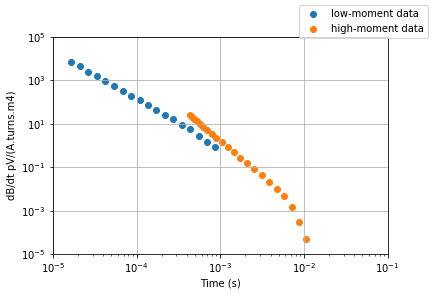

In [6]:
plot_AEM_data(d, 800, error_bars = False)

In [12]:
# print some metadata

print(d['Transmitter'])

print(d['Transmitter']['tx_loop_area'][:])
print(d['Transmitter']['tx_loop_area'].units)

#print(d['Receiver']['Rx_x_component_position_z'][:])

#print(d['Receiver']['Rx_y_component_position_z'][:])

#print(d['Receiver']['Rx_z_component_position_z'][:])

<class 'netCDF4._netCDF4.Group'>
group /Transmitter:
    dimensions(sizes): low_moment_current_time(19), high_moment_current_time(15)
    variables(dimensions): float64 low_moment_current_time(low_moment_current_time), float64 high_moment_current_time(high_moment_current_time), float64 low_moment_waverform_current(low_moment_current_time), float64 high_moment_waverform_current(high_moment_current_time), float64 tx_loop_area()
    groups: 

337.0
m**2


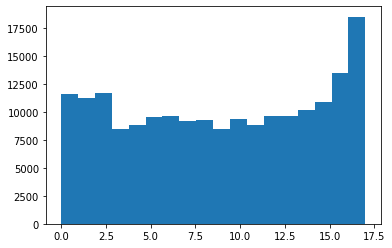

In [8]:
# Find negative transients in low moment gates and
# check out which gates

np.where(d['low_moment_Z-component_EM_data'][:] < 0)

plt.hist(np.where(d['low_moment_Z-component_EM_data'][:] < 0)[1],
        bins = d['low_moment_Z-component_EM_data'][:].shape[1])
plt.show()

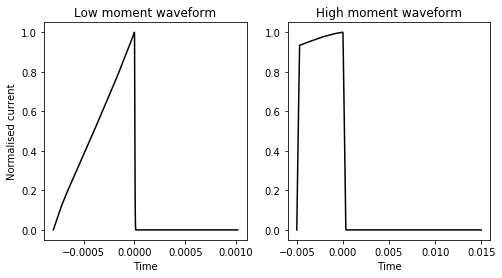

In [13]:
# Plot the waveforms

lm_a = d['Transmitter']['low_moment_waverform_current'][:]

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (8,4))

ax1.plot(d['Transmitter']['low_moment_current_time'][:],
         d['Transmitter']['low_moment_waverform_current'][:], 'k')

ax2.plot(d['Transmitter']['high_moment_current_time'][:],
         d['Transmitter']['high_moment_waverform_current'][:], 'k')

ax1.set_title('Low moment waveform')
ax1.set_xlabel('Time')
ax1.set_ylabel('Normalised current')


ax2.set_title('High moment waveform')
ax2.set_xlabel('Time')

plt.show()

In [14]:

# Open the file with the EM measurements
# Here we use the data response file provided by Niel Christensen
EM_path = os.path.join(nc_dir,'OrdKeep2019_DataResp_cor2DLogOrd.nc')
EM_dataset = netCDF4.Dataset(EM_path)


# Open the file with the many layer model conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

cond_path = os.path.join(nc_dir,'OrdKeep2019_ModeExp_cor2DLogOrd.nc')
cond_dataset = netCDF4.Dataset(cond_path, 'a')


AEM conductivity models are layered earth models. They are are stored as a 2d array wiht shape (point, depth ). The data can also be queried using line number. As it is line data the coordinates are considered variable rather than dimensions.

In [9]:
# Create a variable for contrast ((log conductivity l1)/ (log conductivity l2))

logconductivity = np.log10(cond_dataset['conductivity'][:])

cond_contrast = np.nan*np.ones(shape = logconductivity.shape,
                               dtype = np.float32)

# Get log space conductivity
cond_contrast[:,:-1] = np.divide(logconductivity[:,:-1],
                                logconductivity[:,1:])


try:
    cond_dataset.createVariable("conductivity_contrast","f4",
                               ("point","layer"))
    cond_dataset['conductivity_contrast'][:] = cond_contrast

    cond_dataset['conductivity_contrast'].long_name = 'contrast of log conductivity of layer n to layer n+1'

except RuntimeError:
    print('Variable exists')



Variable exists


In [15]:
# airborne EM inversions and data are typically visualised on a line by line basis

# To utilise the geophys_utils for line data create a NetCDFLineUtils for each dataset

EM_line_utils = NetCDFLineUtils(EM_dataset)
cond_line_utils = NetCDFLineUtils(cond_dataset)
cond_point_utils = NetCDFPointUtils(cond_dataset)

# Display the lines for the conductivity mode

lines = cond_line_utils.line

print(lines)


[100002 100102 100202 100302 100402 100502 100602 100702 100802 100902
 101002 101102 101202 101303 101352 101403 101502 101602 101702 101802
 101803 101902 102002 102102 102202 102301 102402 102502 102602 102702
 102802 102902 103002 200002 200102 200202 200252 200302 200352 200402
 200502 200602 200702 200802 200902 201002 201103 201104 201202 201302
 201402 201502 201503 201602 201702 201802 201902 202002 202102 202202
 202203 202302 202303 202402 202502 202602 202702 202802 202902 202952
 203002 203052 203102 203152 203202 203252 203302 203352 203402 203451
 203502 203552 203602 203652 203702 203802 203902 204002 204102 204203
 204302 204402 204502 204602 204702 204802 204902 205002 205102 300001
 300101 300201 300301 300401 300501 300601 300701 300801 300901 301001
 301101 301201 301301 301401 301501 301601 301701 301801 301901 302001
 302101 302201 302301 302401 302501 302601 302701 302801 302901 303001
 303101 303201 303301 303401 303501 303601 303701 303801 303901 304001
 30410

In [16]:
# Get the data for some lines

variables = ['elevation', 'conductivity']

# Create a generator
cond_gen = cond_line_utils.get_lines(line_numbers = [100002, 100102, 100202,
                                              100302, 100402, 100502],
                                     variables = variables)
    

In [17]:
# Yield the values
line_dict = next(cond_gen)

print(line_dict)

(100002, {'coordinates': array([[128.35600352, -15.43421171],
       [128.35610048, -15.43420295],
       [128.35619744, -15.43419419],
       ...,
       [128.46377008, -15.43446208],
       [128.46390056, -15.43446239],
       [128.46403105, -15.43446271]]), 'elevation': masked_array(data=[ 2.8 ,  2.87,  2.99,  3.12,  3.2 ,  3.19,  3.1 ,  2.97,
                    2.86,  2.81,  2.81,  2.85,  2.92,  3.01,  3.13,  3.28,
                    3.43,  3.56,  3.61,  3.57,  3.47,  3.36,  3.26,  3.19,
                    3.13,  3.07,  3.04,  3.06,  3.12,  3.19,  3.23,  3.23,
                    3.2 ,  3.21,  3.29,  3.44,  3.61,  3.76,  3.86,  3.9 ,
                    3.92,  3.92,  3.92,  3.95,  3.98,  4.02,  4.01,  3.92,
                    3.75,  3.55,  3.36,  3.27,  3.26,  3.33,  3.41,  3.48,
                    3.53,  3.59,  3.67,  3.8 ,  3.96,  4.11,  4.18,  4.12,
                    3.89,  3.5 ,  3.03,  2.58,  2.23,  2.03,  1.98,  2.06,
                    2.23,  2.46,  2.71,  2.94,  3.1

In [18]:
# Only interested in lines beginning with 3 which correspond to 
# our Keep River subset area

Keep_lines = [x for x in lines if np.logical_and(x>300000., x<400000.)]

Keep_mask = cond_point_utils.get_lookup_mask(Keep_lines)

# Get the utm coordinates using the mask created above
utm_wkt, aem_coords = cond_point_utils.utm_coords(cond_point_utils.xycoords[Keep_mask])

# Get the convex hull of the subset
convex_hull = points2convex_hull(aem_coords)

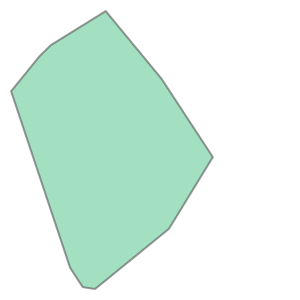

In [19]:
# Create a shapely object of the convex hull
Keep_poly = Polygon(convex_hull)

Keep_poly


In [17]:
# Create an instance of plots for gridding the data
plots = plot_utils.ConductivitySectionPlot(cond_dataset, EM_dataset)

# Define some key variables which we want to inteprolate

plots.conductivity_variables = ['conductivity', 'conductivity_contrast',
                                'data_residual',
                                'tx_height_measured',
                                'depth_of_investigation']

plots.EM_variables  = ['data_values_by_low_moment_gate',
                       'data_values_by_high_moment_gate',
                       'data_response_by_low_moment_gate',
                       'data_response_by_high_moment_gate']

# Subset only the line(s) we want to plot
lines = [305301]

# Define the resolution of th sections
xres, yres = 10., 2.

gridded_vars = plots.grid_variables(xres = xres, yres =yres, lines=lines,
                                    resampling_method = 'linear', 
                                    save_hdf5 = False, return_dict = True)

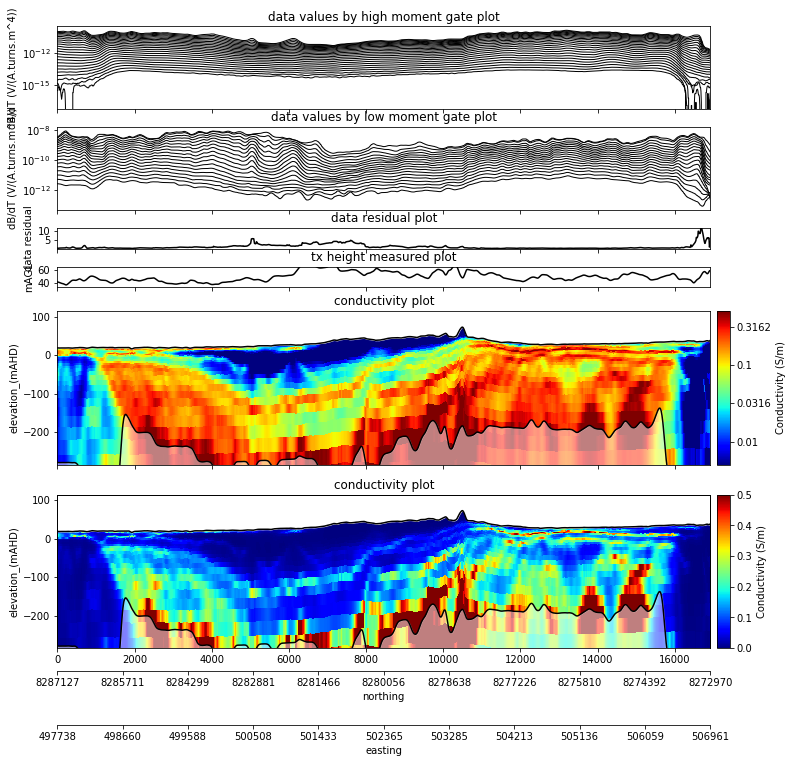

In [18]:
# Define the plot settings
panel_settings = {'panel_1': {'variable': 'data_values_by_high_moment_gate',
                              'plot_type': 'multi_line',
                             'panel_kwargs': {'title': 'high moment data',
                                             'ylabel': 'dB/dT (V/(A.turns.m^4))'},
                             'height_ratio': 2},

                 'panel_2': {'variable': 'data_values_by_low_moment_gate',
                             'plot_type': 'multi_line',
                             'panel_kwargs': {'title': 'low moment data',
                                              'ylabel': 'dB/dT (V/(A.turns.m^4))'},
                             'height_ratio': 2},

                 'panel_3': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'data residual', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 0.5},
                 'panel_4': {'variable': 'tx_height_measured',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'TX height', 'color': 'black',
                                              'ylabel': 'mAGL',
                                              'legend': False},
                             'height_ratio': 0.5},

                 'panel_5': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 300, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.005, 'vmax': 0.5,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration': 10.},
                             'height_ratio': 4},

                 'panel_6': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 300, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0.0, 'vmax': 0.5,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration': 10.},
                             'height_ratio': 4}}

height_ratios = plot_utils.unpack_plot_settings(panel_settings,'height_ratio')
panel_kwargs = plot_utils.unpack_plot_settings(panel_settings, 'panel_kwargs')


# The plot settings can be tinkered with to get a better separation between panels
# This is only required when the vertical exaggeration is set explicitly
plot_settings = {'vertical_margin': 2.5,
                 'panel_vgap': 0.8, 'plot_width': 11.7 #A3 width
                }

# Iterate through lines
for line in lines:

    # Create a matplotlib figure
    fig, ax_array = plt.subplots(len(panel_settings),1, sharex = True,
                                gridspec_kw={'height_ratios': height_ratios,
                                            'wspace':plot_settings['panel_vgap']})

    plot_objs = plot_utils.plot_conductivity_section(ax_array, gridded_vars[line], plot_settings,
                                         panel_settings, save_fig = False, )


    # Set the aspect based on the vertical exageration

    plot_utils.format_panels(ax_array, panel_settings, plot_settings)

    # Tighten the figure

    # Relative position of the colourbar
    x0, y0, width, height = [1.01, 0., 0.02, 1.
                            ]
    # Add coordinate axes to the bottom of the plot
    ax_pos = plot_utils.align_axes(ax_array)

    # Now we want to add the colourbar and coordinates axes
    for i, ax in enumerate(ax_array):
        try:
            if panel_kwargs[i]['colourbar']:

                # Add the colourbar to the plots that the user specifies
                plot_utils.add_colourbar(fig, ax_array[i], plot_objs[i],
                                         x0, y0, width, height, panel_kwargs[i])
        except KeyError:
            pass

    plot_utils.add_axis_coords('northing', gridded_vars[line]['northing'],
                               ax_array[-1], ax_pos[len(panel_settings) - 1], offset=-0.15)

    plot_utils.add_axis_coords('easting', gridded_vars[line]['easting'], ax_array[-1],
                               ax_pos[len(panel_settings) - 1], offset=-0.5)

    plt.show()

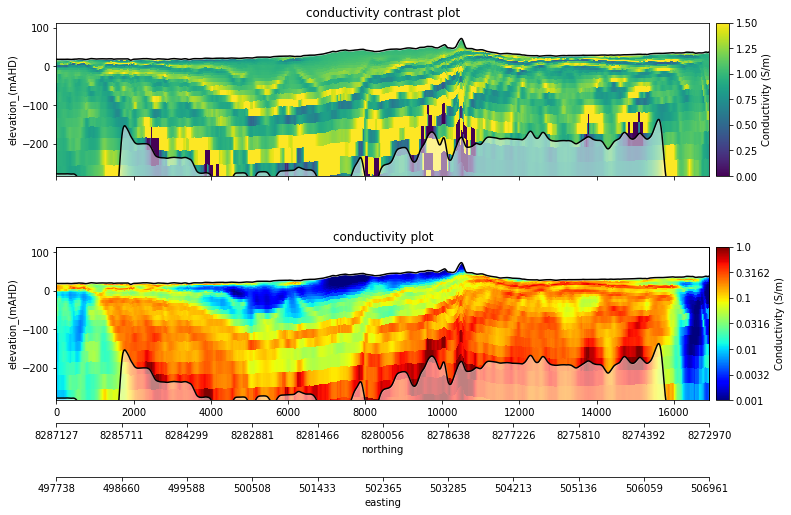

In [19]:
# Define the plot settings
panel_settings = {'panel_1': {'variable': 'conductivity_contrast',
                             'plot_type': 'grid',
                             'panel_kwargs': {'max_depth': 300, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin':0, 'vmax': 1.5,
                                             'cmap': 'viridis', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration': 10.},
                             'height_ratio': 1},

                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 300, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 1.,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration': 10.},
                             'height_ratio': 1}}

height_ratios = plot_utils.unpack_plot_settings(panel_settings,'height_ratio')
panel_kwargs = plot_utils.unpack_plot_settings(panel_settings, 'panel_kwargs')


# The plot settings can be tinkered with to get a better separation between panels
# This is only required when the vertical exaggeration is set explicitly
plot_settings = {'vertical_margin': 2.5,
                 'panel_vgap': 0.8, 'plot_width': 11.7 #A3 width
                }

# Iterate through lines
for line in lines:

    # Create a matplotlib figure
    fig, ax_array = plt.subplots(len(panel_settings),1, sharex = True,
                                gridspec_kw={'height_ratios': height_ratios,
                                            'wspace':plot_settings['panel_vgap']})

    plot_objs = plot_utils.plot_conductivity_section(ax_array, gridded_vars[line], plot_settings,
                                         panel_settings, save_fig = False, )


    # Set the aspect based on the vertical exageration

    plot_utils.format_panels(ax_array, panel_settings, plot_settings)

    # Tighten the figure

    # Relative position of the colourbar
    x0, y0, width, height = [1.01, 0., 0.02, 1.
                            ]
    # Add coordinate axes to the bottom of the plot
    ax_pos = plot_utils.align_axes(ax_array)

    # Now we want to add the colourbar and coordinates axes
    for i, ax in enumerate(ax_array):
        try:
            if panel_kwargs[i]['colourbar']:

                # Add the colourbar to the plots that the user specifies
                plot_utils.add_colourbar(fig, ax_array[i], plot_objs[i],
                                         x0, y0, width, height, panel_kwargs[i])
        except KeyError:
            pass

    plot_utils.add_axis_coords('northing', gridded_vars[line]['northing'],
                               ax_array[-1], ax_pos[len(panel_settings) - 1], offset=-0.15)

    plot_utils.add_axis_coords('easting', gridded_vars[line]['easting'], ax_array[-1],
                               ax_pos[len(panel_settings) - 1], offset=-0.5)

    plt.show()

In [20]:
# Extract borehole data from the database

DB_PATH = r"C:\Users\PCUser\Desktop\EK_data\Boreholes\East_Kimberley_borehole_data.sqlite"

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

connection = engine.connect()

# Open the borehole data as a pandas dataframe

df_header =pd.read_sql('select * from borehole', connection)

# Spatial mask using our polyogn
mask = np.array([Keep_poly.contains(Point(x, y)) for x, y in df_header[['Easting',
                                                                        'Northing']].values])
# subset the header
df_header = df_header[mask]

enos = df_header['borehole_id'].values

# Extract the induction gamma
df_indgam = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                        ['Depth', 'Apparent_conductivity',
                                                         'borehole_id'], connection, enos,
                                                       verbose = True)

select t.Depth, t.Apparent_conductivity, t.borehole_id from induction_gamma_data t where t.borehole_id in (626981,626984,626986,626987,626988,626989,626990,626991,626992,635728,635729,635730,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635921,635957,635958,635959,635960,636181,636183,636184,636185,636191,636193,636194,636195,636198,636201,636204,636205);


select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (626981);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (626984);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (626986);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (626987);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (626988);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (626989);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (626990);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (626991);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (626992);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in 

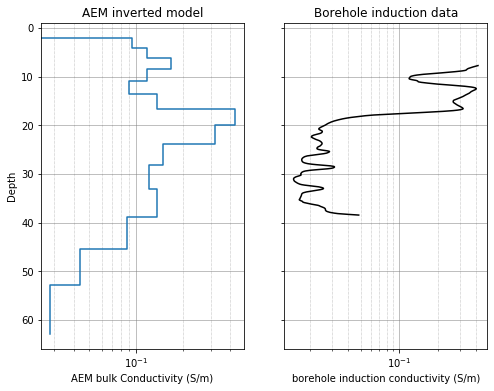

select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (635959);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (635960);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (636181);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (636183);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (636184);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (636185);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (636191);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (636193);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in (636194);
select t.Depth, t.Apparent_conductivity from induction_gamma_data t where t.borehole_id in 

In [21]:
# For a particular borehole lets plot the AEM conductivity v induction

# Extract the AEM conductivity using nearest neighbour
distances, indices = spatial_functions.nearest_neighbours(df_header[['Easting','Northing']],
                                                          aem_coords,
                                                          points_required = 1,# return 10 closest points
                                                          max_distance = 250.)


# Here we will create a table of AEM conductivity profiles for each
# borehole. To guard against anomolous points we will take an inverse
# distance weighting of conductivity from the 10 closest points


for i, (index, row) in enumerate(df_header.iterrows()):
    
    bore_id = df_header.loc[index, 'borehole_id']
    
    # In case of no nearby sites
    if np.isnan(distances[i]).all():
        continue
        
   
   # Extract a representative profile
    df_conductivity_profile = AEM_utils.extract_conductivity_profile(cond_dataset,
                                                   distances[i], indices[i],
                                                   as_dataframe = True,
                                                   mask_below_doi=True)
    # Extract eh inductoin gamma
    df_indgam = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                            ['Depth', 'Apparent_conductivity'],
                                                            connection, 
                                                            [bore_id],
                                                            verbose = True)
    # Create a fiugre
    fig, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (8,6))
        
    # Extract the induction gamm data
    depth, induction_profile = df_indgam['Depth'].values, df_indgam['Apparent_conductivity'].values 
        
    ax2 = plot_utils.plot_downhole_log(ax2, df_indgam['Apparent_conductivity'].values,
                                          df_indgam['Depth'].values, log_plot=True)
        

    # So the plots are on a similar scale we clip the conductivity to
    # the depth of the bore + 20 m
    depth_mask = df_conductivity_profile['Depth_to'] < df_indgam['Depth'].max() + 20.   
      

    ax1 = plot_utils.plot_1D_layered_model(ax1,df_conductivity_profile.loc[depth_mask,'conductivity'].values,
                                  df_conductivity_profile.loc[depth_mask,'Depth_to'].values, doi=None, log_plot=True)
        
        
    ax1.set_title("AEM inverted model")
    ax1.set_ylabel("Depth")
    ax1.set_xlabel("AEM bulk Conductivity (S/m)")
    ax2.set_title("Borehole induction data")

    ax2.set_xlabel("borehole induction conductivity (S/m)")
    
    # Reverse the y axis for deth logical scale
    ax1.set_ylim(ax1.get_ylim()[::-1])
    
    outfile = os.path.join(r"C:\temp\induction_figs", str(bore_id) + '.png')
    #plt.savefig(outfile, dpi=300)
        
    # We plot a pretty example
    if index == df_header[df_header['Borehole_name'] == 'RN040310'].index:
        plt.show()
        
    plt.close()

        

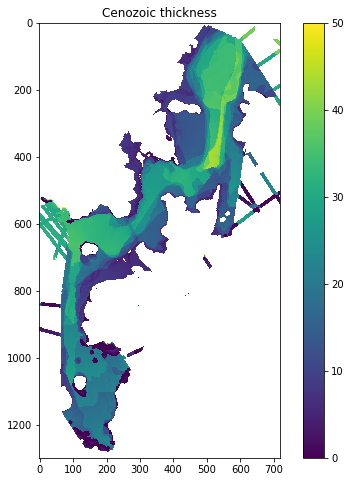

In [21]:
# Bring in an interpreted surface

infile = (r"C:\Users\PCUser\Desktop\EK_data\Interp\KeepRiver_strat_grids\\"
"Cz_base_depth.tif")

cz_base_src = rasterio.open(infile)
cz_base_arr = cz_base_src.read()[0]

# Bring in the elevation

infile = (r"C:\Users\PCUser\Desktop\EK_data\Interp\KeepRiver_strat_grids\\"
"EK_lidar_50m_cz_aligned.tif")

topo_src = rasterio.open(infile)
topo_arr = topo_src.read()

# Remove nulls from topo array
topo_arr[topo_arr < -99.] = np.nan

# Define the elevation of the base of the array
bot_arr= topo_arr[0] - cz_base_arr

cz_thickness = topo_arr[0] - bot_arr
assert topo_arr[0].shape == cz_base_arr.shape

# Plot the thickness of the layer

fig, ax = plt.subplots(figsize = (8,8))
im1 = ax.imshow(cz_thickness, vmin = 0, vmax = 50.)
fig.colorbar(im1)
ax.set_title('Cenozoic thickness')
plt.show()

In [22]:
# Create a grid onto which we will be interpolating

nrow, ncol = cz_base_arr.shape[0], cz_base_arr.shape[1]

xr, yr = np.abs(cz_base_src.transform.a), np.abs(cz_base_src.transform.e)


# Get the lower left coordinates for x and y-offset inputs into grid
xoff = cz_base_src.bounds.left
yoff = cz_base_src.bounds.bottom

# Create a structured grid
cz_grid = grid_utils.StructuredGrid(delr = np.array(ncol * [yr]),
                                    delc = np.array(nrow * [xr]),
                                    top=topo_arr[0],#
                                    botm=np.expand_dims(bot_arr, axis=0),
                                    proj4=cz_base_src.crs.to_proj4(),
                                    xoff = xoff,
                                    yoff = yoff,
                                    nlay = 1,
                                    lenuni=2, # units are metres
                                    nrow= nrow,
                                    ncol = ncol
                                    )

In [23]:
# Extract the geospatial information

nrow, ncol = cz_base_arr.shape[0], cz_base_arr.shape[1]

xr, yr = np.abs(cz_base_src.transform.a), np.abs(cz_base_src.transform.e)

minx, maxx, miny, maxy = cz_grid.extent

# Find the layer indices that intersect with 
depth_inds = np.where(np.logical_and(cond_dataset['layer_top_depth'][0] <= np.nanmax(cz_base_arr),
                     cond_dataset['layer_top_depth'][0] >= np.nanmin(cz_base_arr)))[0]

print(depth_inds.shape)

(19,)


In [54]:
# Define gdal algorithm as string - see https://gdal.org/programs/gdal_grid.html
algorithm = 'invdist:power=2:radius1=250:radius2=250:max_points=10:'
algorithm += 'min_points=2:nodata=-32768.0'

grid_kwargs = {'conductivity': {'log_grid': True,
                                'gdal_algorithm': algorithm}}

start_time = time.time()

# Currently this is too resource intense, need to make it more effecient
aem_grid = spatial_functions.grid_points_gdal(cond_point_utils,
                 grid_resolution = xr,
                 variables = 'conductivity',
                 reprojected_grid_bounds = (minx, miny, maxx, maxy),
                 grid_wkt = utm_wkt,
                 point_step=4, # Only use every 4th point
                 grid_kwargs = grid_kwargs,
                 depth_inds = depth_inds)

print("Gridding time: ", time.time() - start_time, ' seconds')

Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finished gridding  temp_grid.tif
Gridding  temp_grid.tif
Finishe

In [24]:
# Save the multidimensional array onto disc or open to from disc

outfile = os.path.join(r"C:\temp", 'AEGC_sample_AEM_grids.npy')

#np.save(outfile, aem_grid['conductivity'])

aem_grid = {}

aem_grid['geotransform'] = (493550.0, 50.0, 0.0, 8261300.0, 0.0, 50.0)

aem_grid['wkt'] = utm_wkt
aem_grid['conductivity'] = np.load(outfile)

# Finall we remove the 2 cell buffer and flip up down

aem_grid['conductivity'] = aem_grid['conductivity'][:,2:-2,2:-2][:,::-1,:]

# Create an array with depth of the top layer which for this upper
# unit is 0
cz_top_arr = np.zeros(shape = aem_grid['conductivity'][0].shape,
                      dtype = np.float32)

# Where the unit is absent set the values to null
cz_top_arr[np.isnan(cz_base_arr)] = np.nan

In [25]:
aem_grid['conductivity'].shape

(19, 1300, 720)

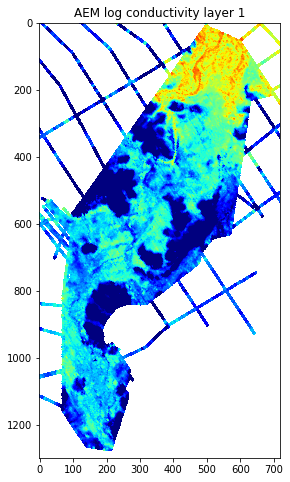

In [26]:
# Plot the log10 of the weighted average grid
fig, ax1 = plt.subplots(1, figsize = (8,8))
ax1.set_title('AEM log conductivity layer 1')
im1 = ax1.imshow(np.log10(aem_grid['conductivity'][0]),
                cmap = 'jet', vmin = -2, vmax=1)
c1 = fig.colorbar(im1, ax=ax)
c1.set_label('log conductivity (S/m)')

In [27]:
# Calculate the weighted average of conductivity for the layer

#import importlib
#importlib.reload(spatial_functions)

wt_ave_grid = spatial_functions.weighted_average(cond_dataset['layer_top_depth'][0],
                                aem_grid['conductivity'],
                               cz_top_arr, cz_base_arr)

In [37]:
wt_ave_grid.shape

(1300, 720)

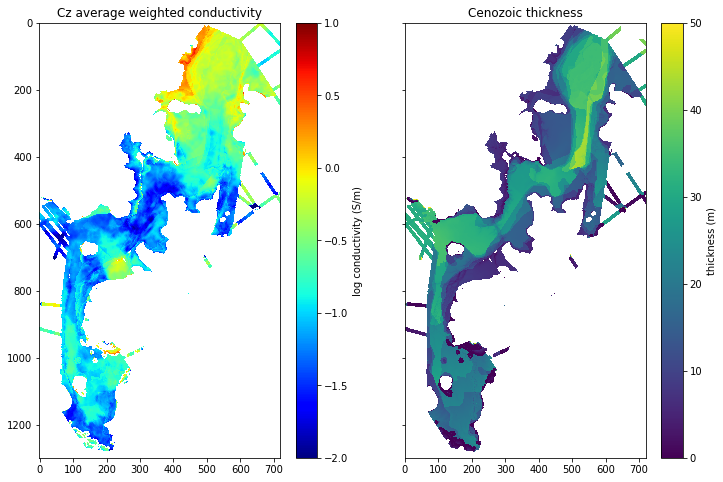

In [28]:
# Plot the log10 of the weighted average grid
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,8),
                             sharey = True)
ax1.set_title('Cz average weighted conductivity')
im1 = ax1.imshow(np.log10(wt_ave_grid),
                cmap = 'jet', vmin = -2, vmax=1)
c1 = fig.colorbar(im1, ax=ax1)
c1.set_label('log conductivity (S/m)')

# Plot the thickness of the layer

im2 = ax2.imshow(cz_thickness,
                 vmin = 0, vmax = 50.)
c2 = fig.colorbar(im2, ax=ax2)
c2.set_label('thickness (m)')
ax2.set_title('Cenozoic thickness')
plt.show()